# Autoencoder for MNIST compared to supervised model

### Imports and load the MNIST dataset

In [447]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalize data
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Supervised split
supervised_split = 0.01
train_split = 0.8

# Data where labels are available
supervised_images = x_train[:int(supervised_split * len(x_train))]
supervised_labels = y_train[:int(supervised_split * len(y_train))]

# Data where labels are not available
unsupervised_images = x_train[int(supervised_split * len(x_train)):]
unsupervised_labels = y_train[int(supervised_split * len(y_train)):]

# Split both supervised and unsupervised data into train and validation
supervised_train_images = supervised_images[:int(train_split * len(supervised_images))]
supervised_train_labels = supervised_labels[:int(train_split * len(supervised_labels))]
supervised_val_images = supervised_images[int(train_split * len(supervised_images)):]
supervised_val_labels = supervised_labels[int(train_split * len(supervised_labels)):]

unsupervised_val_images = unsupervised_images[:int(train_split * len(unsupervised_images))]
unsupervised_val_images = unsupervised_images[int(train_split * len(unsupervised_images)):]

unsupervised_val_labels = unsupervised_labels[int(train_split * len(unsupervised_labels)):]

# Exstract input shape
input_shape = x_train.shape[1:] # (28, 28)

print(f"Supervised train images shape: {supervised_train_images.shape}")
print(f"Supervised train labels shape: {supervised_train_labels.shape}")
print(f"Supervised val images shape: {supervised_val_images.shape}")
print(f"Supervised val labels shape: {supervised_val_labels.shape}")
print(f"Unsupervised train images shape: {unsupervised_val_images.shape}")
print(f"Unsupervised val images shape: {unsupervised_val_images.shape}")

print(f'Test images shape: {x_test.shape}')
print(f'Test labels shape: {y_test.shape}')


Supervised train images shape: (480, 28, 28)
Supervised train labels shape: (480,)
Supervised val images shape: (120, 28, 28)
Supervised val labels shape: (120,)
Unsupervised train images shape: (11880, 28, 28)
Unsupervised val images shape: (11880, 28, 28)
Test images shape: (10000, 28, 28)
Test labels shape: (10000,)


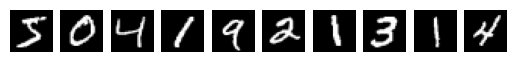

In [448]:
# Plot the first 10 images
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(x_train[i], cmap='gray')
    plt.axis('off')

In [402]:
# Add noise to the images
noise_factor = 0.3
x_train_noise = unsupervised_images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=unsupervised_images.shape)
x_test_noise = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

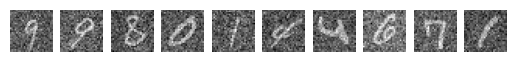

In [403]:
# Print the same 10 images with noise
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(x_train_noise[i], cmap='gray')
    plt.axis('off')

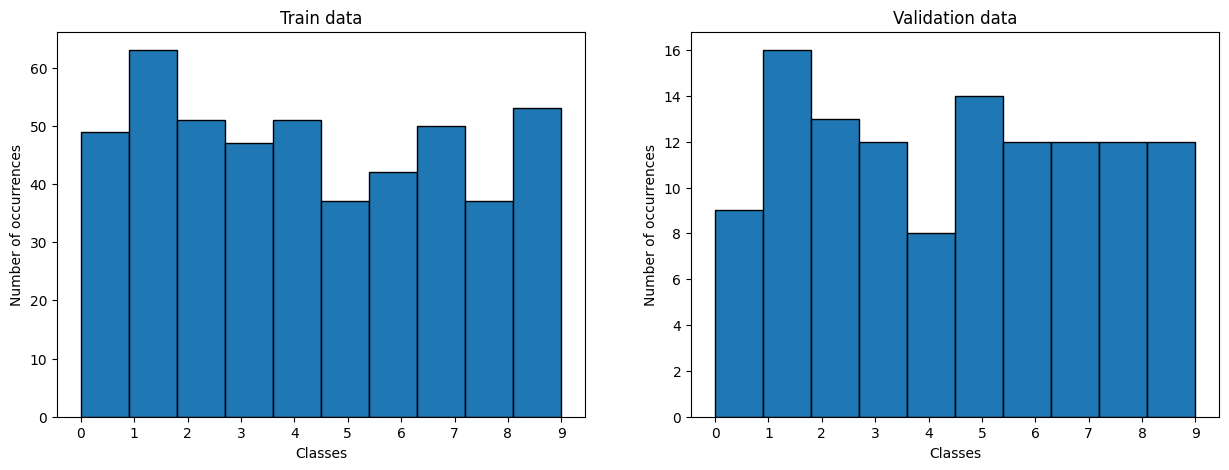

In [452]:
fig, axs = plt.subplots(1,2,figsize=(15,5)) 
axs[0].hist(supervised_train_labels, ec='black')
axs[0].set_title('Train data')
axs[0].set_xlabel('Classes') 
axs[0].set_ylabel('Number of occurrences')
axs[1].hist(supervised_val_labels, ec='black')
axs[1].set_title('Validation data')
axs[1].set_xlabel('Classes') 
axs[1].set_ylabel('Number of occurrences')
# We want to show all ticks...
axs[0].set_xticks(np.arange(10))
axs[1].set_xticks(np.arange(10))

plt.show()

### Vector size for latent variables and number of epochs

In [453]:
LATENT_SIZE = 32
EPOCHS_UNSUPERVISED = 100
EPOCHS_SUPERVISED = 100

### Define the autoencoder model consisting of an encoder and decoder

In [454]:
# Autoencoder using Dense layers
encoder = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=input_shape),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(LATENT_SIZE, activation="relu")
])

decoder = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(784, activation="sigmoid"),
    tf.keras.layers.Reshape(input_shape)
])

img = tf.keras.layers.Input(shape = input_shape)
latent_vector = encoder(img)
output = decoder(latent_vector)
autoencoder = tf.keras.models.Model(inputs = img, outputs = output)

encoder_weights_before_pre_train = encoder.get_weights()

### Compile and train the autoencoder

In [455]:
autoencoder.compile("adam", loss = "mean_squared_error")

autoencoder.summary()

history = autoencoder.fit(unsupervised_images, unsupervised_images, epochs=EPOCHS_UNSUPERVISED, shuffle=True, validation_data=(unsupervised_val_images, unsupervised_val_images))

# Get the weights of the encoder in the autoencoder after pre-training
encoder_weights_after_pre_train = autoencoder.layers[1].get_weights()

assert not np.array_equal(encoder_weights_before_pre_train[0], encoder_weights_after_pre_train[0]), "The weights of the encoder have not changed after pre-training"

Model: "model_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 28, 28)]          0         
                                                                 
 sequential_209 (Sequential)  (None, 32)               110816    
                                                                 
 sequential_210 (Sequential)  (None, 28, 28)           111568    
                                                                 
Total params: 222,384
Trainable params: 222,384
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1857/1857 [==============================] - 5s 2ms/step - loss: 0.0308 - val_loss: 0.0192
Epoch 2/100
1857/1857 [==============================] - 4s 2ms/step - loss: 0.0166 - val_loss: 0.0146
Epoch 3/100
1857/1857 [==============================] - 4s 2ms/step - loss: 0.0134 - val_loss: 0.0125
Epoch 4

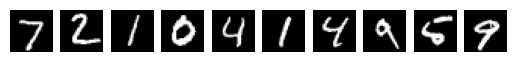

In [456]:
# Plot the 10 first images in the test set
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(x_test[i], cmap='gray')
    plt.axis('off')

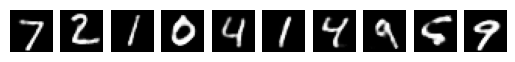

In [457]:
# Predict the first 10 images for the test set
predicted = autoencoder.predict(x_test[:10], verbose=0)

for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(predicted[i], cmap='gray')
    plt.axis('off')


### Plot the autoencoder loss

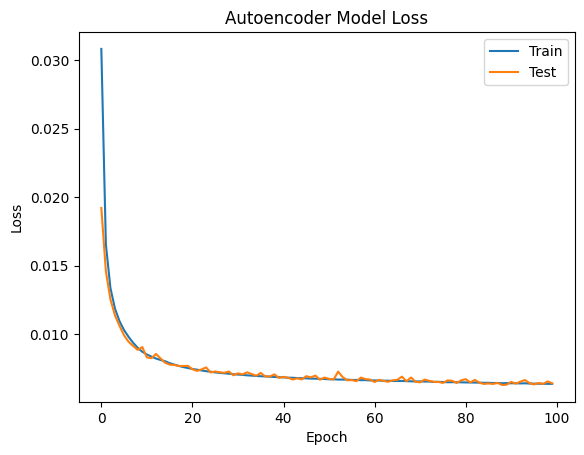

In [458]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Autoencoder Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [459]:
# Save the encoder part of the autoencoder
autoencoder.save('../models/autoencoder.h5')

### Fine-tune the model with supervised learning with 10% of the training data

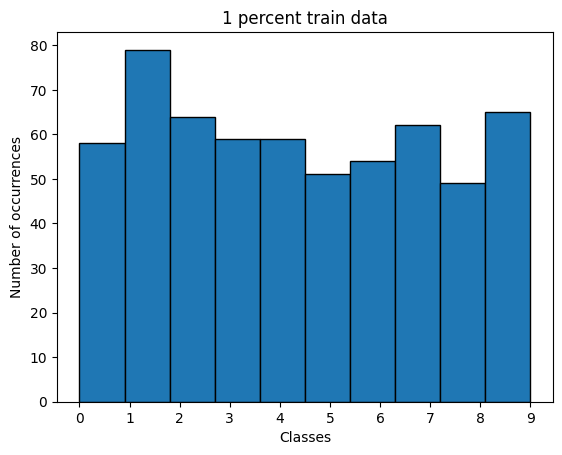

In [460]:
plt.plot(figsize=(10,5)) 
plt.hist(supervised_labels, ec='black')
plt.title('1 percent train data')
plt.xlabel('Classes') 
plt.ylabel('Number of occurrences')
plt.xticks(np.arange(10))
plt.show()

In [496]:
# Get the saved encoder
LOAD = True

if LOAD:
    autoencoder = tf.keras.models.load_model('../models/autoencoder.h5')

encoder = autoencoder.layers[1]

# Set up the model
fine_tune_model = tf.keras.models.Sequential([
    encoder,
    tf.keras.layers.Dense(10, activation="softmax")
])

fine_tune_model.summary()

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Compile the model
fine_tune_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

# Train the model
history_autoencoder = fine_tune_model.fit(
    supervised_train_images,
    supervised_train_labels,
    validation_data=(supervised_val_images, supervised_val_labels),
    epochs=EPOCHS_SUPERVISED,
    verbose=2,
    callbacks=[callback]
)

# Evaluate the model on the test set
res_unsupervised = fine_tune_model.evaluate(x_test, y_test)
print(f"Loss, Accuracy after fine-tuning: {res_unsupervised}")

Model: "sequential_237"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_209 (Sequential)  (None, 32)               110816    
                                                                 
 dense_529 (Dense)           (None, 10)                330       
                                                                 
Total params: 111,146
Trainable params: 111,146
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
15/15 - 1s - loss: 3.7738 - accuracy: 0.1250 - val_loss: 2.6074 - val_accuracy: 0.1917 - 765ms/epoch - 51ms/step
Epoch 2/100
15/15 - 0s - loss: 1.7642 - accuracy: 0.4104 - val_loss: 1.7867 - val_accuracy: 0.3667 - 51ms/epoch - 3ms/step
Epoch 3/100
15/15 - 0s - loss: 1.0880 - accuracy: 0.6771 - val_loss: 1.3820 - val_accuracy: 0.5500 - 51ms/epoch - 3ms/step
Epoch 4/100
15/15 - 0s - loss: 0.7634 - accuracy: 0.8062 - val_loss: 1.

Predicted:  7
Predicted:  2
Predicted:  1
Predicted:  0
Predicted:  4
Predicted:  1
Predicted:  4
Predicted:  9
Predicted:  5
Predicted:  9


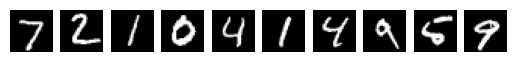

In [497]:
# Predict some images from the test set
predicted = fine_tune_model.predict(x_test[:10], verbose=0)

for i in range(10):
    print("Predicted: ", np.argmax(predicted[i]))
    plt.subplot(1, 10, i+1)
    plt.imshow(x_test[i], cmap='gray')
    plt.axis('off')

## Training a FNN model supervised on 1% of the labeled data

In [500]:
# Set up the model using dense layers
supervised_model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=input_shape),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(LATENT_SIZE, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

# Compile the model
supervised_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Train the model
history_supervised = supervised_model.fit(
    supervised_train_images,
    supervised_train_labels,
    validation_data=(supervised_val_images, supervised_val_labels),
    epochs=EPOCHS_SUPERVISED,
    verbose=2,
    callbacks=[callback]
)

# Evaluate the model on the test set
res_supervised = supervised_model.evaluate(x_test, y_test, verbose=0)
print(f"Loss, Accuracy : {res_supervised}")

Epoch 1/100
15/15 - 1s - loss: 2.1228 - accuracy: 0.2625 - val_loss: 1.9609 - val_accuracy: 0.3583 - 770ms/epoch - 51ms/step
Epoch 2/100
15/15 - 0s - loss: 1.4499 - accuracy: 0.6333 - val_loss: 1.4038 - val_accuracy: 0.6417 - 48ms/epoch - 3ms/step
Epoch 3/100
15/15 - 0s - loss: 0.7879 - accuracy: 0.8250 - val_loss: 1.0416 - val_accuracy: 0.6917 - 52ms/epoch - 3ms/step
Epoch 4/100
15/15 - 0s - loss: 0.4440 - accuracy: 0.8979 - val_loss: 0.9588 - val_accuracy: 0.6833 - 52ms/epoch - 3ms/step
Epoch 5/100
15/15 - 0s - loss: 0.2937 - accuracy: 0.9187 - val_loss: 0.9137 - val_accuracy: 0.7417 - 50ms/epoch - 3ms/step
Epoch 6/100
15/15 - 0s - loss: 0.2081 - accuracy: 0.9417 - val_loss: 0.8609 - val_accuracy: 0.7417 - 50ms/epoch - 3ms/step
Epoch 7/100
15/15 - 0s - loss: 0.1491 - accuracy: 0.9688 - val_loss: 0.8163 - val_accuracy: 0.7750 - 50ms/epoch - 3ms/step
Epoch 8/100
15/15 - 0s - loss: 0.0986 - accuracy: 0.9854 - val_loss: 0.8175 - val_accuracy: 0.8000 - 48ms/epoch - 3ms/step
Epoch 9/100
15

Predicted:  7
Predicted:  2
Predicted:  1
Predicted:  0
Predicted:  4
Predicted:  1
Predicted:  4
Predicted:  9
Predicted:  4
Predicted:  9


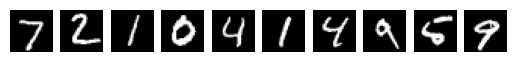

In [501]:
# Predict some images from the test set
predicted = supervised_model.predict(x_test[:10], verbose=0)

for i in range(10):
    print("Predicted: ", np.argmax(predicted[i]))
    plt.subplot(1, 10, i+1)
    plt.imshow(x_test[i], cmap='gray')
    plt.axis('off')

In [502]:
# Save the model
supervised_model.save('../models/supervised_model.h5')

### Plot the history accuracy of the two models

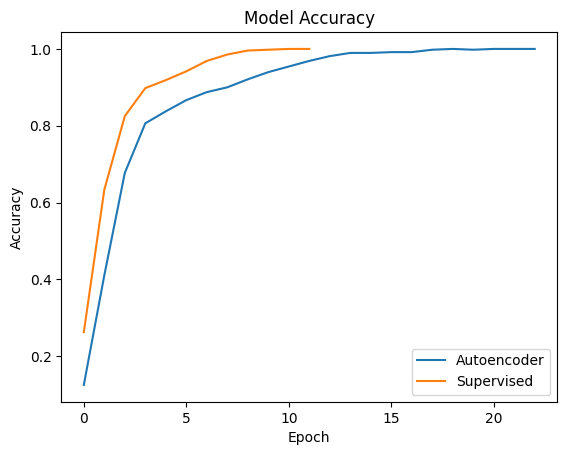

In [503]:
plt.plot(history_autoencoder.history['accuracy'])
plt.plot(history_supervised.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Autoencoder', 'Supervised'], loc='lower right')
plt.show()

### Compare the performance of the autoencoder and FNN models

In [511]:
print(f'Unsupervised pre-trained FNN autoencoder with supervised fine-tuning accuracy: {res_unsupervised[1]}')
print(f'Supervised FNN accuracy: {res_supervised[1]}')
print()

# Get the absolute difference between the two models
diff = abs(res_unsupervised[1] - res_supervised[1])
# Get percentage difference
diff = diff / res_supervised[1] * 100
# Round to 2 decimals
diff = round(diff, 2)

if res_unsupervised[1] > res_supervised[1]:
    print(f'Unsupervised pre-trained autoencoder with supervised 1% labels fine-tuning performs better by {diff}%')
else:
    print(f'Supervised classifier with 1% labels is better by {diff} percent')

Unsupervised pre-trained FNN autoencoder with supervised fine-tuning accuracy: 0.8413000106811523
Supervised FNN accuracy: 0.8198999762535095

Unsupervised pre-trained autoencoder with supervised 1% labels fine-tuning performs better by 2.61%


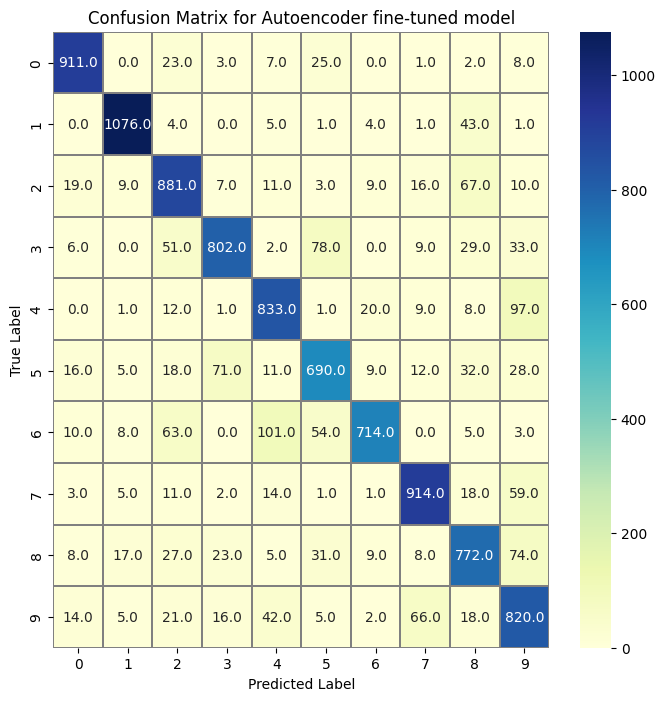

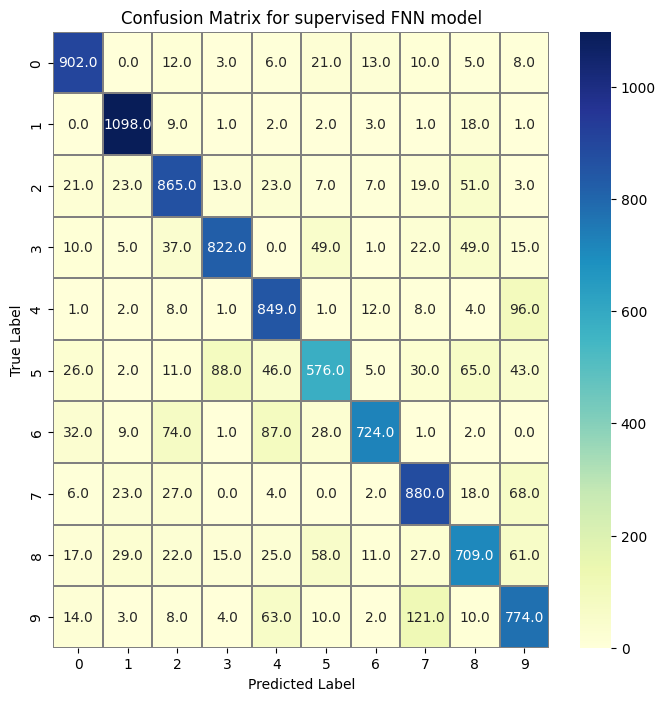

In [512]:
# Seaborn heatmap of confusion matrix

# Predict the values from the validation dataset
Y_pred = fine_tune_model.predict(x_test, verbose=0)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred, axis=1)
# Convert validation observations to one hot vectors
Y_true = y_test

# Compute the confusion matrix
confusion_mtx = tf.math.confusion_matrix(Y_true, Y_pred_classes)

# Plot the confusion matrix
f, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01, cmap="YlGnBu", linecolor="gray", fmt='.1f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Autoencoder fine-tuned model")


# Predict the values from the validation dataset
Y_pred = supervised_model.predict(x_test, verbose=0)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred, axis=1)
# Convert validation observations to one hot vectors
Y_true = y_test

# Compute the confusion matrix
confusion_mtx = tf.math.confusion_matrix(Y_true, Y_pred_classes)

# Plot the confusion matrix
f, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01, cmap="YlGnBu", linecolor="gray", fmt='.1f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for supervised FNN model")
plt.show()